# UC San Diego: Neural Data Science
## Analyzing Gene Expression in Alzheimer's Disease <br> Associated Brain Regions: A Data-Driven Approach

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [ X ] NO - keep private

# Names

- Amy Hardy 

# Overview

This project had three main goals:
* Determine which areas of the brain were most statistically related to Alzheimer's disease
* In these areas, indentify genes are being over- or under-expressed
* Determine if my research hypothesis is correct

To do this, I used three publicly available datasets: Neurosynth, the Allen Human Brain Atlas, and a gene cell-type classification dataset. Neurosynth and AHBA data were downloaded and parcellated in order to be able to analyze them together, on the same scale. This included using Abagen and Neuromaps toolboxes and determining how to deal with missing data and zero-heavy data. The third dataset was used at the end of the analysis, to answer my hypothesis. 

<a id='research_question'></a>
# Research Question

* Which genes are over- or under-expressed in brain regions associated with Alzheimer’s disease, and can these gene expression profiles provide us with more information on the role that microglia play within the disease, specifically in their inability to clear beta amyloid? 

<a id='background'></a>

## Background & Prior Work

Alzheimer’s disease (AD), a neurodegenerative disease characterized by amyloid plaques and neurofibrillary tangles in the brain, is one of the leading causes of death globally and although there have been advances in research over the last few decades, the genetic processes behind the disease are not fully understood [1]. Abnormally high levels of beta-amyloid seen in the disease are suspected to be the cause of cell death and a loss in neural connectivity, as it clumps together and blocks pathways in the brain. <br> <br>
Microglia, a type of glial cell, can be thought of as the “clean-up” crew in the nervous system. In a healthy functioning brain, they act as macrophages, removing debris, toxins, and dead cells. This includes build-up of beta-amyloid. However, in AD, microglia have been shown to exhibit an “activated proinflammatory phenotype” that disrupts their ability to remove beta-amyloid. Without beta-amyloid being properly disposed of, deposits accumulate and form plaques [2]. <br> <br>
The end goal of this study is to develop a deeper understanding of the complex genetic profile of Alzheimer’s disease and potentially discover a link between it and the microglial activation and functionality seen in neuroinflammation from traumatic brain injury (TBI). Adults over the age of 65 are the at highest risk for both AD and TBI, and the intersection between the two is not well understood. It has been demonstrated that “post-injury microglia are primed and become hyper-reactive,” resulting in an “inflammatory continuum” when doubled with AD. Beta- amyloid has also been shown to accumulate within hours following a TBI [3]. This suggests that there may be a coinfluence between AD and TBI that results in worsening symptoms of both that makes recovery nearly impossible. Before this intersection can be studied, it’s crucial to understand the genetic expressions in AD and the ways in which that can affect microglia and high levels of beta-amyloid. This understanding may lead to advances in treatment and early diagnosis of the disease.

See References at the end of the notebook. <br>

# Hypothesis

In this analysis, it is suspected that the genes shown to be are under- or over-expressed in brain regions most statistically associated with Alzheimer's disease will preferentially be expressed in microglia cells.

# Datasets

- **Dataset Name**: Neurosynth
- **Link to the dataset**: https://neurosynth.org 
- **Number of observations**: (91, 109, 91)
- **Data reduction**: Neuromaps (a toolbox for comparing brain maps) parcellater was used for data reduction of the downloaded Alzheimer's disease association map. It takes volumetric data and parcellates it in regards to a specified atlas.

Neurosynth, a platform for automatic meta-analysis, synthesizes data from approximately 15,000 neuroimaging studies that are published with corresponding fMRI voxel coordinates and provides probabilistic measures of a particular voxel being associated with a given term. In this analysis, we downloaded the association maps for the term "Alzheimer". There were 267 published studies that Neurosynth identified as being associated with Alzheimer's disease. 

- **Dataset Name**: Allen Human Brain Atlas
- **Link to the dataset**: https://human.brain-map.org/static/download
- **Number of observations**: Each of the 6 microarray gene expression matrices provide information on over 20,000 genes across 3702 brain tissue samples.
- **Data reduction**: Abagen (https://abagen.readthedocs.io) was used for data reduction. Abagen,a Python toolbox developed by Markello et.al, fetches AHBA microarray data, updates MNI coordinates, removes probes under threshold by means of intensity-based filtering, normalizes tissue samples and gene expression, and parcelates the data into a user-specified atlas size.

The Allen Human Brain Atlas provides regional microarray gene expression data, collected from six post-mordem brains. 

- **Dataset Name**: Gene Cell Types
- **Link to the dataset**: https://github.com/netneurolab/hansen_genescognition/blob/master/CTD/celltypes_PSP.csv
- **Number of observations**: 7160  

This data set is a list of gene names preferentially expressed in each of seven cell types. It was obtained from ...


In order to analyze gene expression in Alzheimer's disease associated brain areas, we will use the parcellation methods described above (abagen and neuromaps parcellation) as a dimension reduction technique in order to correlate the two datasets. Both were parcellated using the Desikan Killiany atlas, which is comprised of 68 cortical regions. [Figure x]

# Data Wrangling

### Necessary Imports

In [2]:
import scipy.io
import numpy as np 
import pandas as pd
import abagen
from abagen import images
from nilearn import image
from nilearn import plotting
import nibabel as nib 
from neurosynth.analysis import classify
from netneurotools import datasets as nntdata
from neuromaps.parcellate import Parcellater
from neuromaps.plotting import plot_surf_template
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting
import ggseg
import matplotlib
import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})
sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})

### Step 0. Desikan Killiany Atlas for Parcellations

Using the Abagen toolbox, we defined this parcelation using the line of code shown below. It will allow us to process the AHBA and Neurosynth data in a similar manner. The atlas downloads as a NIFTI image in MNI space and a CSV with information (labels, hemisphere, structure) on the parcellation scheme is provided, which assists in constraining the brain tissue samples to specific anatomical regions in the atlas. Defining <code>surface=True</code> specifies that the atlas will be the surface version rather than volumetric. 

<code>atlas = abagen.fetch_desikan_killiany(surface=True)</code>

In [3]:
desikan_info = pd.read_csv('final_files/final_atlas_info.csv')
desikan_info.shape

(68, 3)

In [4]:
desikan_info

,label,hemisphere,structure
0,bankssts,L,cortex
1,caudalanteriorcingulate,L,cortex
2,caudalmiddlefrontal,L,cortex
3,cuneus,L,cortex
4,entorhinal,L,cortex
...,...,...,...
63,precentral,R,cortex
64,precuneus,R,cortex
65,rostralanteriorcingulate,R,cortex
66,rostralmiddlefrontal,R,cortex


As shown here, this atlas will divide the surface of the brain into 68 cortical regions in <code>fsaverage5</code> space. It is worth noting that this atlas is low-resolution and therefore may lead to an over simplification of the data, however when ranked as level of importance and impact, other parameter choices showed to be more influential than atlas type. 

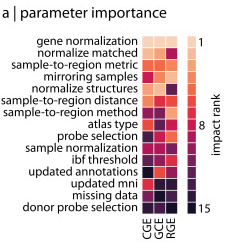

In [5]:
parameter_importance = Image(filename='elife_parameter.jpg')
parameter_importance

### Step 1. Alzheimer's Disease Association Map from Neurosynth

In [7]:
anatomical = nib.load('files/anatomical.nii')
AD_association = nib.load('files/alzheimer_association-test_z_FDR_0.01.nii')

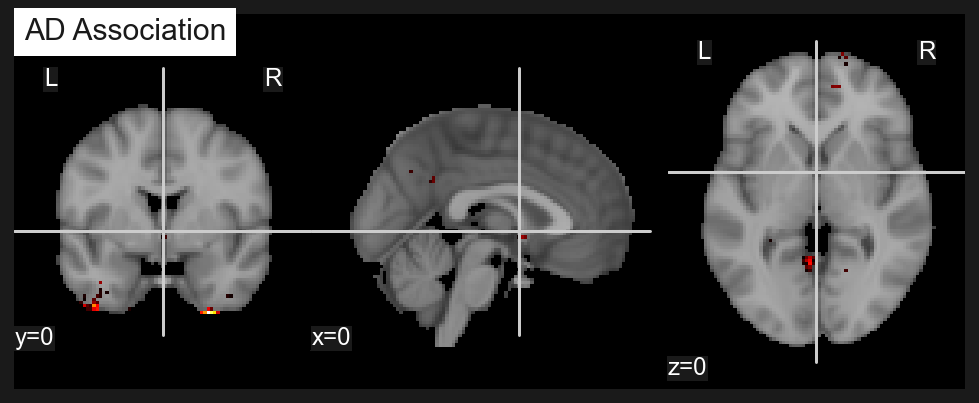

In [9]:
display = plotting.plot_anat(anatomical, cut_coords=(0,0,0),title='AD Association')
display.add_overlay(AD_association, cmap=plotting.cm.black_red, threshold=0)

<code>anatomical = nib.load('files/anatomical.nii')
AD_association = nib.load('files/alzheimer_association-test_z_FDR_0.01.nii')
AD_association.shape >> (91, 109, 91)
display = plotting.plot_anat(anatomical, cut_coords=(0,0,0), figure=fig, title='AD Association')
display.add_overlay(AD_association, cmap=plotting.cm.black_red, threshold=0)</code>

The <code>anatomical</code> file was loaded from Neurosynth and acts as a foundation for the visualization seen in Figure [1]. Nilearn plotting was used to create the image, with <code>AD_association</code>, which is described as "z-scores from a two-way ANOVA testing for the presence of a non-zero association between term use and voxel activation. FDR-corrected (the value after that is the specific false positive rate used in the correction, e.g., 0.01)," added as an overlay."

#### Parcellating Neurosynth Data

<code>parc = Parcellater('atlas-desikankilliany.nii.gz', 'mni152')
neurosynth_parc_final = parc.fit_transform(AD_association,'mni152')</code>

In [5]:
AD_association_df = pd.read_csv('final_files/final_AD_col.csv')
AD_association_df_corrected_rows = pd.read_csv('final_files/final_AD_drop_rows_68.csv')
AD_association_df_corrected_rows.shape

(68, 1)

In [6]:
AD_association_df_corrected_rows[:10]

,AD Association
0,0.000000
1,0.000000
2,0.000000
3,0.125202
4,0.000000
5,0.653232
6,0.002969
7,0.067715
8,0.000000
9,0.004591


This results in a 68 region x 1 Neurosynth term matrix. <br> <br>
**More information on association tests from Neurosynth.org**: 
> "The <u>association test</u> maps provides somewhat different (and, in our view, typically more useful) information. Whereas the uniformity test maps tell you about the consistency of activation for a given term, **the association test maps tell you whether activation in a region occurs more consistently for studies that mention the current term than for studies that don't**. So for instance, the fact that the amygdala shows a large positive z-score in the association test map for emotion implies that studies whose abstracts include the word 'emotion' are more likely to report amygdala activation than studies whose abstracts don't include the word 'emotion'. That's important, because it controls for base rate differences between regions. Meaning, some regions (e.g., dorsal medial frontal cortex and lateral PFC) play a very broad role in cognition, and hence tend to be consistently activated for many different terms, despite lacking selectivity. **The association test maps let you make slightly more confident claims that a given region is involved in a particular process**, and isn't involved in just about every task."

### Step 2. Gene Expression Data from Allen Human Brain Atlas

<code>expression_killiany, report = abagen.get_expression_data(atlas['image'], info, missing='centroids', return_report=True)</code>

In [7]:
# 68 regions, 15633 genes
AHBA = pd.read_csv('final_files/final_expression_killiany_68.csv')
AHBA.shape

(68, 15633)

In [8]:
AHBA.head()

,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
0,0.440726,0.589278,0.381510,0.436797,0.467330,0.483065,0.452128,0.543946,0.536256,0.588966,...,0.486024,0.533246,0.522263,0.601487,0.587398,0.405509,0.634875,0.497207,0.666547,0.477138
1,0.678336,0.431307,0.572806,0.671694,0.480824,0.503408,0.355954,0.368647,0.556326,0.584441,...,0.387346,0.363805,0.343892,0.549072,0.387021,0.633337,0.349052,0.223801,0.406646,0.503784
2,0.520608,0.446375,0.609580,0.459314,0.501768,0.542337,0.516451,0.527325,0.416930,0.433428,...,0.486235,0.506752,0.408213,0.448193,0.453520,0.438250,0.429106,0.587044,0.404144,0.529791
3,0.317040,0.307230,0.451889,0.477776,0.474542,0.471519,0.687771,0.399432,0.566165,0.440505,...,0.590275,0.526024,0.370078,0.550802,0.423469,0.451572,0.444684,0.829026,0.733465,0.387726
4,0.711983,0.261514,0.699565,0.514992,0.455938,0.476981,0.313874,0.296195,0.600913,0.489880,...,0.368767,0.372662,0.779778,0.435531,0.376815,0.562862,0.542200,0.085269,0.453389,0.591145


<code>ABHA</code> was created using Abagen, where <code>atlas['image']</code> is the brain parcellation file mentioned above. It is a 68 region x 15633 gene matrix.

#### Allen Human Brain Atlas / Abagen Methods
Regional microarry expression data were obtained from 6 post-mortem brains (1 female, ages 24.0--57.0, 42.50 +/- 13.38) provided by the Allen Human Brain Atlas (AHBA, https://human.brain-map.org; [H2012N]). Data were processed with the abagen toolbox (version 0.1.3; https://github.com/rmarkello/abagen) using a 83-region volumetric atlas in MNI space.

First, microarray probes were reannotated using data provided by [A2019N]; probes not matched to a valid Entrez ID were discarded. Next, probes were filtered based on their expression intensity relative to background noise [Q2002N], such that probes with intensity less than the background in >=50.00% of samples across donors were discarded , yielding 31,569 probes . When multiple probes indexed the expression of the same gene, we selected and used the probe with the most consistent pattern of regional variation across donors (i.e., differential stability; [H2015N]), calculated with:

$$ \Delta_{{S}}(p) = \frac{{1}}{{\binom{{N}}{{2}}}} \, \sum_{{i=1}}^{{N-1}} \sum_{{j=i+1}}^{{N}} \rho[B_{{i}}(p), B_{{j}}(p)] $$

where $ \rho $ is Spearman's rank correlation of the expression of a single probe, p, across regions in two donors $B_{{i}}$ and $B_{{j}}$, and N is the total number of donors. Here, regions correspond to the structural designations provided in the ontology from the AHBA. 

The MNI coordinates of tissue samples were updated to those generated via non-linear registration using the Advanced Normalization Tools (ANTs; https://github.com/chrisfilo/alleninf). Samples were assigned to brain regions in the provided atlas if their MNI coordinates were within 2 mm of a given parcel. All tissue samples not assigned to a brain region in the provided atlas were discarded. 

Inter-subject variation was addressed by normalizing tissue sample expression values across genes using a robust sigmoid function [F2013J]:

$$ x_{{norm}} = \frac{{1}}{{1 + \exp(-\frac{{(x-\langle x \rangle)}} {{\text{{IQR}}_{{x}}}})}} $$

where $\langle x \rangle$ is the median and $\text{{IQR}}_{{x}}$ is the normalized interquartile range of the expression of a single tissue sample across genes. Normalized expression values were then rescaled to the unit interval: 

$$ x_{{scaled}} = \frac{{x_{{norm}} - \min(x_{{norm}})}} {{\max(x_{{norm}}) - \min(x_{{norm}})}} $$

Gene expression values were then normalized across tissue samples using an identical procedure. Samples assigned to the same brain region were averaged separately for each donor and then across donors, yielding a regional expression matrix with 83 rows, corresponding to brain regions, and 15,633 columns, corresponding to the retained genes.

### Step 3. Gene Cell Type Dataframe

The last data needed for this analysis is the gene cell type dataframe, which contains 7159 genes classified into seven classes (see <code>classes</code> below). This was obtained from Hansen et.al **"Mapping gene transcription and neurocognition across human neocortex" 2021**.

In [9]:
cell_types = pd.read_csv('celltypes.csv')

In [10]:
cell_types[600::1000]

,gene,class
600,DAG1,Astro
1600,ASAP1-IT2,Endo
2600,FCHSD2,Micro
3600,FOXP2,Neuro-Ex
4600,NFAT5,Neuro-Ex
5600,SCLT1,Neuro-In
6600,CDC42EP2,Oligo


In [11]:
classes = list(cell_types['class'].unique())
classes

['Astro', 'Endo', 'Micro', 'Neuro-Ex', 'Neuro-In', 'Oligo', 'OPC']

Cell types: ASTRO = astrocyte, MICRO = microglia, OPC = oligodendrocyte precursor, OLIGO = oligodendrocyte, ENDO = endothelial, NEURO-EX = excitatory neurons, NEURO-IN = inhibitory neurons, NULL = empirically derived null distribution.

# Data Cleaning

* Some of the data cleaning took place during the data wrangling process, for example being able to load in the AHBA data with the Desikan Killiany atlas and parcellating the Neurosynth data in the same way, resulting in similarly formatted data to work with. Also, as described in the AHBA methods, data interpolation in terms of accounting for missing or null values was offered as a parameter to set at download. Selecting 'centroid' for this parameter means "the empty regions in the atlas will be assigned the expression values of the tissue sample falling closest to the centroid of that region." At this point, we have the AD association dataframe, for which many of the values are 0.0 and will disrupt the analysis. Additionally, we are given 15633 genes to focus on, which may be too many for the purposes of this project. Therefore, the next steps will include 1) combining our first two datasets, 2) leaving out the zero-valued rows of AD association, 3) data reduction in terms of the amount of genes or columns.

### Combine Neurosynth and ABHA

Because we are focusing on only one term from the Neurosynth database ('alzheimer'), the most efficient way to combine the data was to merge the parcellated Alzheimer's disease single column dataframe (68 x 1) with the parcellated Allen Human Brain Atlas gene expression dataframe (68 x 15633), resulting in a (68 parcel x 15633 gene + 1 association) matrix.

In [12]:
# 68 regions x 15633 genes + 1 association col
neurosynth_abha = pd.read_csv('final_files/final_full_df.csv')
neurosynth_abha.shape

(68, 15634)

In [13]:
neurosynth_abha.head()

,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,AD Association
0,0.440726,0.589278,0.381510,0.436797,0.467330,0.483065,0.452128,0.543946,0.536256,0.588966,...,0.533246,0.522263,0.601487,0.587398,0.405509,0.634875,0.497207,0.666547,0.477138,0.000000
1,0.678336,0.431307,0.572806,0.671694,0.480824,0.503408,0.355954,0.368647,0.556326,0.584441,...,0.363805,0.343892,0.549072,0.387021,0.633337,0.349052,0.223801,0.406646,0.503784,0.000000
2,0.520608,0.446375,0.609580,0.459314,0.501768,0.542337,0.516451,0.527325,0.416930,0.433428,...,0.506752,0.408213,0.448193,0.453520,0.438250,0.429106,0.587044,0.404144,0.529791,0.000000
3,0.317040,0.307230,0.451889,0.477776,0.474542,0.471519,0.687771,0.399432,0.566165,0.440505,...,0.526024,0.370078,0.550802,0.423469,0.451572,0.444684,0.829026,0.733465,0.387726,0.125202
4,0.711983,0.261514,0.699565,0.514992,0.455938,0.476981,0.313874,0.296195,0.600913,0.489880,...,0.372662,0.779778,0.435531,0.376815,0.562862,0.542200,0.085269,0.453389,0.591145,0.000000


### Including Only Non-Zero Values for AD Association 

In [14]:
neurosynth_abha_no_zeros = neurosynth_abha

In [15]:
neurosynth_abha_no_zeros = neurosynth_abha_no_zeros.drop(neurosynth_abha_no_zeros[neurosynth_abha_no_zeros['AD Association'] == 0].index)
neurosynth_abha_no_zeros.head()

,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,AD Association
3,0.317040,0.307230,0.451889,0.477776,0.474542,0.471519,0.687771,0.399432,0.566165,0.440505,...,0.526024,0.370078,0.550802,0.423469,0.451572,0.444684,0.829026,0.733465,0.387726,0.125202
5,0.649082,0.586919,0.444880,0.455946,0.459009,0.440558,0.392492,0.587864,0.476909,0.499418,...,0.578880,0.569464,0.568967,0.542161,0.553512,0.518018,0.371762,0.474775,0.573677,0.653232
6,0.419474,0.443861,0.415128,0.498819,0.456800,0.527704,0.520872,0.498450,0.471002,0.474903,...,0.520520,0.414961,0.512980,0.507755,0.455405,0.556910,0.631584,0.527076,0.436674,0.002969
7,0.640879,0.636120,0.408960,0.518881,0.447463,0.385537,0.427574,0.581712,0.483490,0.517509,...,0.537434,0.582859,0.524989,0.468680,0.488486,0.518801,0.400729,0.475119,0.544534,0.067715
9,0.313056,0.301562,0.509786,0.509053,0.504859,0.517165,0.602175,0.464204,0.475238,0.485174,...,0.547123,0.441554,0.611824,0.490398,0.512516,0.503895,0.729325,0.705525,0.413119,0.004591


In [16]:
f'no zeros: {neurosynth_abha_no_zeros.shape} vs with zeros: {neurosynth_abha.shape}'

'no zeros: (31, 15634) vs with zeros: (68, 15634)'

### Gene Reduction

In [17]:
abha_gene_list = set([x for x in neurosynth_abha_no_zeros.columns])
cell_type_list = set([x for x in cell_types['gene']])
in_both = [x for x in abha_gene_list if x in cell_type_list]
NEW_GENES_SET = in_both
NEW_GENES_SET.append('AD Association')
drop_cols = [x for x in neurosynth_abha_no_zeros.columns if x not in NEW_GENES_SET]

In [18]:
gene_reduction = neurosynth_abha_no_zeros

In [19]:
gene_reduction_df = gene_reduction.drop([col for col in gene_reduction.columns if col not in NEW_GENES_SET], axis=1, inplace=False)


In [20]:
print(f'original: neurosynth_abha_no_zeros {neurosynth_abha_no_zeros.shape}')
print(f'after gene reduction: gene_reduction_df {gene_reduction_df.shape}')

original: neurosynth_abha_no_zeros (31, 15634)
after gene reduction: gene_reduction_df (31, 4111)


#### Adding a Column for log of AD Association

In [21]:
gene_reduction_df['log AD'] = np.log(gene_reduction_df['AD Association'])
gene_reduction_df.head()

,A2M,A2ML1,A4GALT,AADAT,AAED1,AAK1,AASS,AATK,ABAT,ABCA2,...,ZNF91,ZNHIT6,ZNRF2,ZNRF3,ZSCAN29,ZSWIM6,ZYG11B,ZZZ3,AD Association,log AD
3,0.451889,0.477776,0.471519,0.440505,0.437323,0.769831,0.458061,0.506371,0.686336,0.456302,...,0.467465,0.574494,0.388460,0.510773,0.621338,0.602261,0.444684,0.387726,0.125202,-2.077829
5,0.444880,0.455946,0.440558,0.499418,0.526693,0.468305,0.446646,0.496598,0.456034,0.546217,...,0.489758,0.444437,0.583564,0.473460,0.368299,0.496322,0.518018,0.573677,0.653232,-0.425823
6,0.415128,0.498819,0.527704,0.474903,0.506212,0.626656,0.416218,0.498137,0.579148,0.451667,...,0.482252,0.504746,0.471206,0.443913,0.558975,0.460916,0.556910,0.436674,0.002969,-5.819623
7,0.408960,0.518881,0.385537,0.517509,0.520878,0.403351,0.461933,0.505006,0.484057,0.500224,...,0.442831,0.461207,0.521518,0.502546,0.454737,0.515248,0.518801,0.544534,0.067715,-2.692452
9,0.509786,0.509053,0.517165,0.485174,0.397946,0.673592,0.399270,0.527755,0.643459,0.495374,...,0.516372,0.574162,0.436348,0.457437,0.620609,0.499410,0.503895,0.413119,0.004591,-5.383596


#### Adding a binary column to <code>cell_types.csv</code>  'is_microglia' (yes/no)

In [22]:
cell_types['is_micro'] = np.where(cell_types['class']=="Micro",1,0)
cell_types[600::1000]

,gene,class,is_micro
600,DAG1,Astro,0
1600,ASAP1-IT2,Endo,0
2600,FCHSD2,Micro,1
3600,FOXP2,Neuro-Ex,0
4600,NFAT5,Neuro-Ex,0
5600,SCLT1,Neuro-In,0
6600,CDC42EP2,Oligo,0


# Data Visualization

### Figure 1

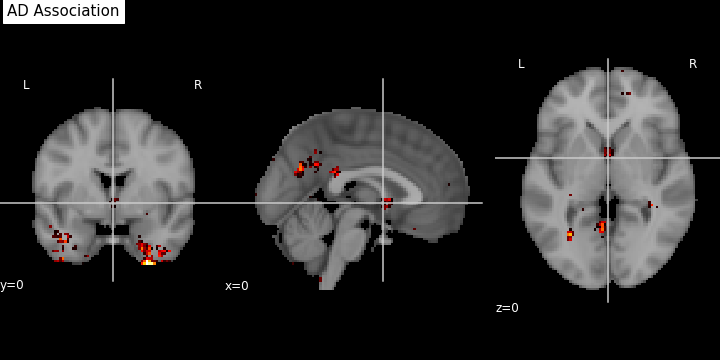

In [23]:
neurosynth_display = Image(filename='ADplot.png')
neurosynth_display

<code>data = {}
for i in range(len(info)):
    if info['hemisphere'][i] == 'L':
        data[info['label'][i]+'_left'] = val[i]
    data[info['label'][i]+'_right'] = val[i]
ggseg.plot_dk(data, background='k', edgecolor='w', cmap='Spectral', 
              bordercolor='gray', ylabel='Cortical thickness (mm)', title='Title of the figure')</code>

### Figure 2

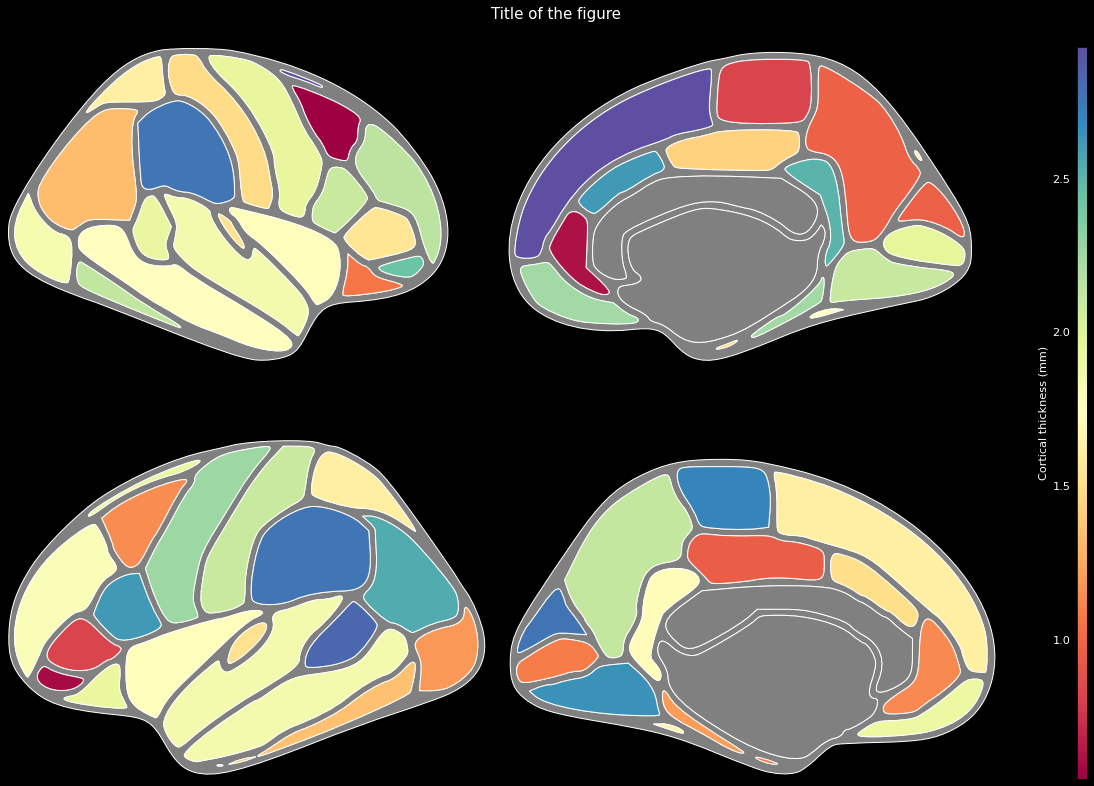

In [24]:
parcellation_surf = Image(filename='parcellation_surf.png')
parcellation_surf

# Data Analysis & Results

# Correlation of AD Association and 4110 Genes

#### Using Log AD Association

In [25]:
# correlation between log AD column and all genes
AD_log_corr = gene_reduction_df[gene_reduction_df.columns].corr()['log AD']

> Correlation Stats: **Mean:** -0.005, **Min:** -0.58, **Max:** 0.55, **Standard deviation:** 0.17

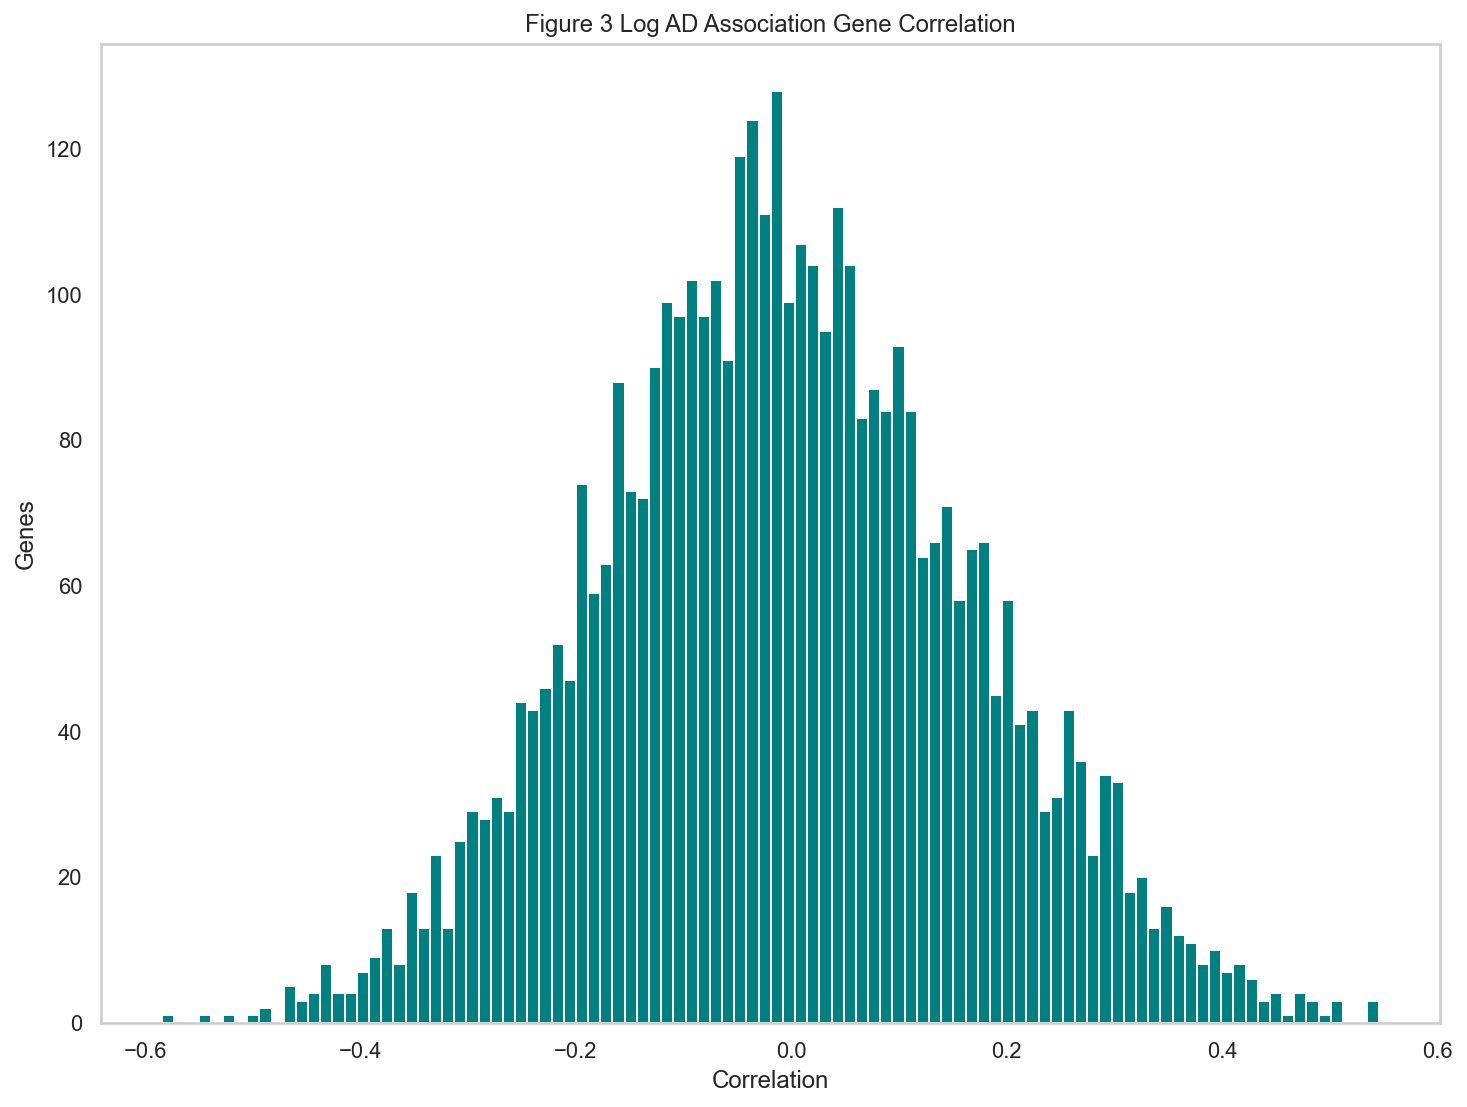

In [26]:
plt.title('Figure 3 Log AD Association Gene Correlation')
plt.ylabel('Genes')
plt.xlabel('Correlation')
log_hist_bins = plt.hist(AD_log_corr[:-2], bins=100, color='teal')

Note: The last two values of <code>AD_log_corr</code> are 'AD association' and 'log AD' so we will omit these values.

#### Using AD Association

In [27]:
# correlation between AD col (not log) and all genes
AD_corr = gene_reduction_df[gene_reduction_df.columns].corr()['AD Association']

> Correlation Stats: **Mean:** -0.005, **Min:** -0.45, **Max:** 0.44, **Standard deviation:** 0.13

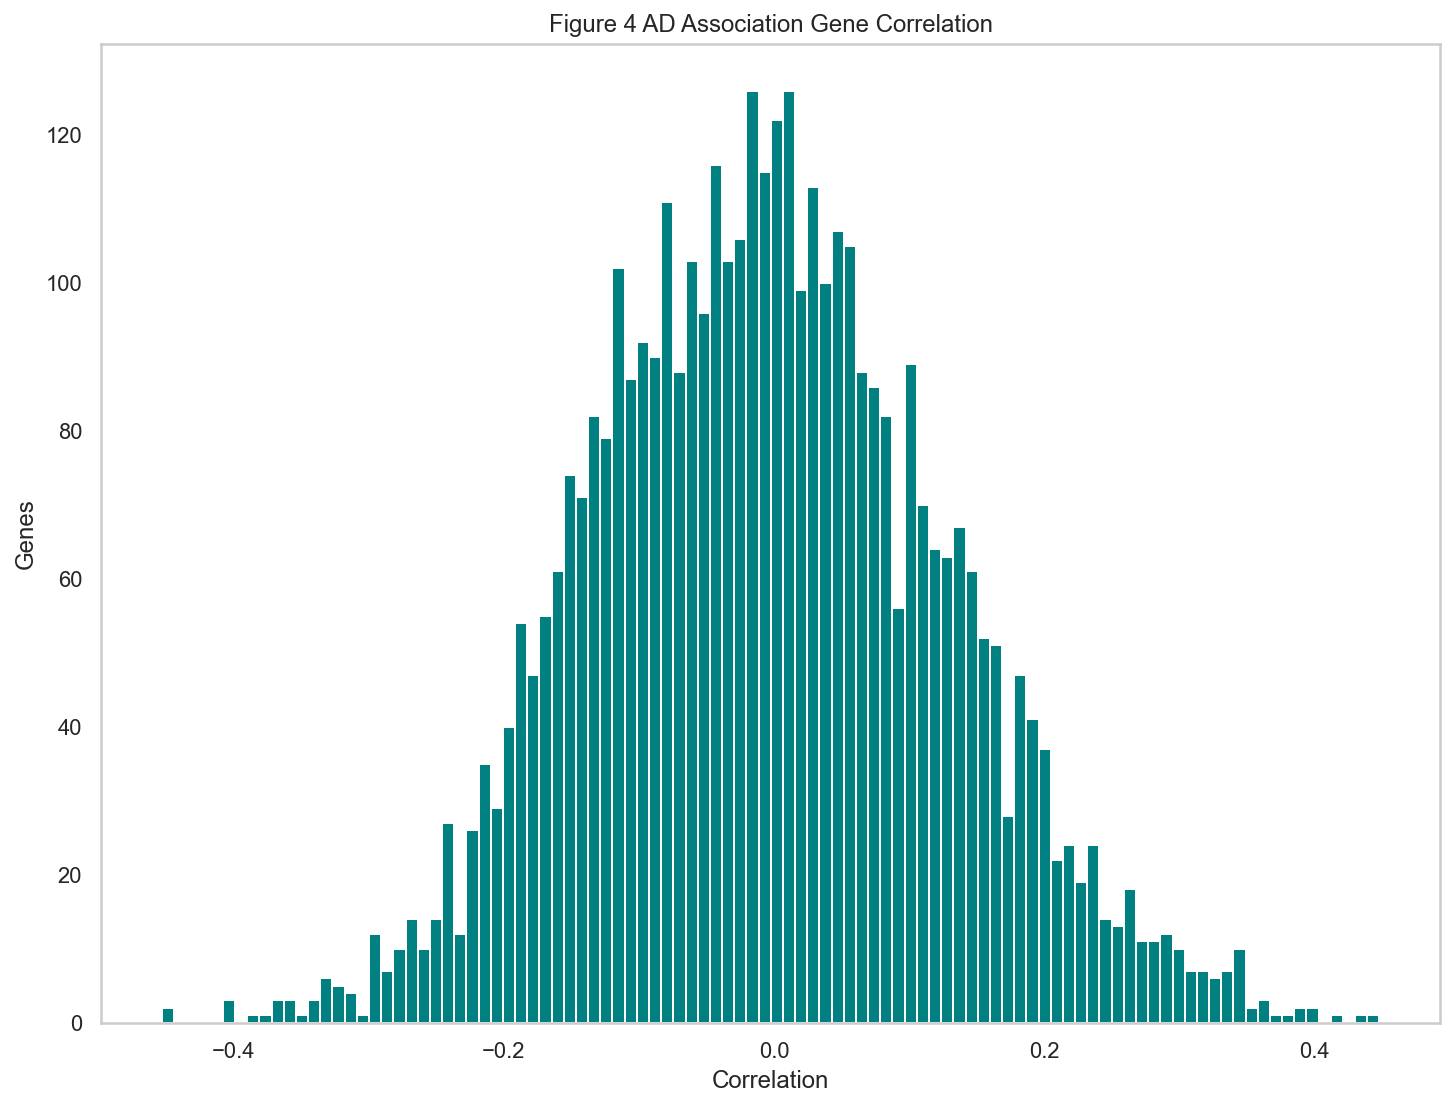

In [28]:
plt.title('Figure 4 AD Association Gene Correlation')
plt.ylabel('Genes')
plt.xlabel('Correlation')
ad_hist_bins = plt.hist(AD_corr[:-2], bins=100, color='teal')

### Correlation between <code>AD_log_corr</code> and <code>micro_genes</code>

Using the <code>cell_types</code> CSV, we will make a list of 'microglia genes', where a gene will be added if it is mentioned as being related to microglia at least once (note: most genes in the file appear multiple times, as they often are related to multiple cell types) and that list will be compared to our columns in <code>gene_reduction_df</code> to create a binary <code>micro_array</code>. In the <code>cell_types</code> CSV, 1072 genes were categorized as 'microglia genes."

"The point biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship."

In [29]:
micro_genes = []
for row in cell_types.index:
    if cell_types['is_micro'][row] == 1:
        micro_genes.append(cell_types['gene'][row])

In [30]:
len(micro_genes)

1072

In [31]:
micro_array = np.array([1 if x in micro_genes else 0 for x in gene_reduction_df.columns])

In [32]:
AD_gene_r = np.array([x for x in AD_log_corr])

In [33]:
print(micro_array[::1000])
print(AD_gene_r[::1000])

[0 0 1 0 1]
[-0.18926544  0.00103048 -0.00894485 -0.29684312 -0.05919092]


In [34]:
from scipy import stats

In [35]:
pb_r, pb_p_val = stats.pointbiserialr(AD_gene_r, micro_array)

In [36]:
pb_r

-0.015141275984018314

In [37]:
pb_p_val

0.3317012165406275

In [40]:
highly_corr_genes = []
for i in range(len(AD_log_corr)):
    if AD_log_corr[i] < -0.35 or AD_log_corr[i] > 0.35:
        highly_corr_genes.append(AD_log_corr.index[i])
        #print(AD_log_corr.index[i], AD_log_corr[i])
len(highly_corr_genes)

170

In [42]:
out = ''
for i in range(len(highly_corr_genes[:-2])):
    out += f'{i+1}.{highly_corr_genes[i]} \n'
#print(out)

In [45]:
'SUCNR1' in highly_corr_genes

False

In [49]:
st = 'IGSF6, ADORA3, ALOX5AP, CSF2RA, HPGDS, P2RY13, ACY3, SUSD3, SASH3, TBXAS1, RASAL3'
for gene in st.split(', '):
    print(gene in highly_corr_genes)

False
False
False
False
False
False
False
False
False
False
False


# Conclusion & Discussion

In this analysis, the main goal was to used public datasets to identify which brain areas were most statistically related to Alzheimer's disease and determine which genes were over- or under-expressed in these areas. By leveraging data manipulation, formatting, and cleaning techniques, combined with the parcellated Neurosynth and Allen Brain Institute data, we were able to identify these regions and find genes whose expression was highly correlated with Alzheimer's associations. <code>highly_correlated_genes</code> can be altered based on threshold to find these genes. For instance **CEP112, DOPEY1, GNA14, MGST3, NLGN1, PTPRM, RAD9A, RASGEF1B, SLC16A3, SSBP2** were ten of the most highly correlated genes to AD association. 

It was hypothesized that these genes, when classified by cell type would be most likely to be classified as microglia genes. This was done by using <code>cell_types</code> CSV, which also allowed data reduction as we took genes that were not in the file out of the analysis, and finally comparing the binary <code>micro_array</code> to the array of correlation coefficients for log AD association. For this, point biserial correlation was used because it can accurately measure the relationship between a binary variable and a continuous variable. In these results, it was found that the hypothesis was incorrect, with a p-value of 0.33. However, many recent studies have linked microglia cells to Alzheimer's disease, so it may be required to continue analysis of this topic in different ways. For example, leveraging different means of determining relationships between data, manipulating the data in other ways, or using different data. One reasonable change would be to use a different dataset for categorizing genes by cell-type.

The main limitation of this project was the learning curve when it came to working with neuroimaging and gene expression data for the first time, and the span of the project. That being said, I plan to first go over all computed values and means of parcellation, to ensure it was completed in the most efficient way for my specific question, start researching other ways of determining relationships between the data, and look for more datasets that can make the results more meaningful. In the end, this project allowed for a much deeper understanding of neural data science and how these large public datasets can be combined in ways such that they can answer new questions.</font>

### References

---------- 
> [1] https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death

> [2] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3653296/ 

> [3] https://www.frontiersin.org/articles/10.3389/fimmu.2018.00672/full

> [4] https://pubmed.ncbi.nlm.nih.gov/33767429/


Abagen Generated References <br>
>[A2019N]: Arnatkevic̆iūtė, A., Fulcher, B. D., & Fornito, A. (2019). A practical guide to linking brain-wide gene expression and neuroimaging data. Neuroimage, 189, 353-367. </br>

>[F2013J]: Fulcher, B. D., Little, M. A., & Jones, N. S. (2013). Highly comparative time-series analysis: the empirical structure of time series and their methods. Journal of the Royal Society Interface, 10(83), 20130048. </br>

>[H2012N]: Hawrylycz, M. J., Lein, E. S., Guillozet-Bongaarts, A. L., Shen, E. H., Ng, L., Miller, J. A., ... & Jones, A. R. (2012). An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416), 391-399. </br>

>[H2015N]: Hawrylycz, M., Miller, J. A., Menon, V., Feng, D., Dolbeare, T., Guillozet-Bongaarts, A. L., ... & Lein, E. (2015). Canonical genetic signatures of the adult human brain. Nature Neuroscience, 18(12), 1832. </br>

>[Q2002N]: Quackenbush, J. (2002). Microarray data normalization and transformation. Nature Genetics, 32(4), 496-501.